# Distancia entre oraciones sucesivas corpus revista CELL
## distancia de coseno entre el par de palabras mas cercano de oraciones sucesivas!

In [1]:
import numpy as np
import random
from nltk import sent_tokenize
from nltk.tokenize import RegexpTokenizer
tokenizer = RegexpTokenizer(r'\w+')
import itertools
from scipy import spatial
import networkx as nx
import ast
import re
from joblib import Parallel, delayed
import multiprocessing
import pandas as pd
import random

data=open('stopwords.txt','r')
data_read = data.read()
stop_words=data_read.replace('\n',' ').split()

vectors = {}
f = open('glove.6B.300d.txt')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    vectors[word] = coefs
f.close()

## vectores aleatorios para las palabras fuera de vocabulario (se mantienen iguales para el mismo texto)

In [2]:
def glove_text(text):
    text=list(set([w.lower() for w in tokenizer.tokenize(text)]))
    text=[w for w in text if w not in stop_words]
    glove_vectors={}
    for w in text:
        if w not in vectors.keys():
            vector=[1]*300
            vector=[x*random.uniform(-1.5,1.5) for x in vector]
            vector=np.array(vector)
            glove_vectors[w]=vector
        else:
            glove_vectors[w]=vectors[w]
    return glove_vectors

## distancias entre palabras y oraciones

In [22]:
def simglove(vector_i,vector_j):
    return 1-spatial.distance.cosine(vector_i.reshape(1,-1),vector_j.reshape(1,-1))

def sent_distance(text,index_sent_i,index_sent_j): 
    glove_vectors=glove_text(text)
    sentences=sent_tokenize(text)
    sent_i=list(set([w.lower() for w in tokenizer.tokenize(sentences[index_sent_i])]))
    sent_i=[w for w in sent_i if w not in stop_words]
    sent_j=list(set([w.lower() for w in tokenizer.tokenize(sentences[index_sent_j]) if w not in stop_words]))
    sent_j=[w for w in sent_j if w not in stop_words]

    p=list(itertools.product(sent_i,sent_j))
    d=[]
    for item in p:
        d+=[simglove(glove_vectors[item[0]],glove_vectors[item[1]])]
    if len(d)==0:
        return -2
    else:
        return max(d)
    
def average_succesive(text): 
    average=0
    n=len(sent_tokenize(text))
    pairs=list(zip(range(n),range(n)[1:]))
    p=0
    for pair in pairs:
        r=sent_distance(text,pair[0],pair[1])
        if r!=-2:
            average+=r
            p+=1
        
    return average/float(p)

## introducciones revista CELL

In [48]:
data = open('corpus_cell.json','r')
data_cell=data.read()
data_cell = ast.literal_eval(data_cell)
introductions=[' '.join(item['introduction']) for item in data_cell]
introductions=[re.sub("[\(\[].*?[\)\]]", "", item) for item in introductions]
introductions=[x for x in introductions if len(x)>0]
introductions=[' '.join([s for s in sent_tokenize(text) if len(s)>1]) for text in introductions]

## distancia entre oraciones sucesivas introducciones CELL

In [39]:
text=introductions[0]
average_succesive(text)

0.8731669220659468

In [40]:
n=multiprocessing.cpu_count()

average_succesive_data=Parallel(n_jobs=n)(delayed(average_succesive)(text) for text in introductions)


In [41]:
succesive_dict={x:[y] for x,y in zip(range(len(average_succesive_data)),average_succesive_data)}

C=pd.DataFrame(succesive_dict)
C.to_csv('succesive_min_dist.csv')

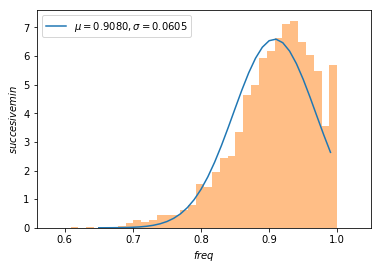

In [44]:
import scipy
import matplotlib.pyplot as plt
from scipy.stats import norm
import matplotlib.mlab as mlab
from scipy import stats  

data = np.array(average_succesive_data) 

t=scipy.stats.mstats.normaltest(data)

bins = np.arange(0.65, 1.0, 0.01) # fixed bin size

m, s = stats.norm.fit(data) 
pdf_g = norm.pdf(bins, m, s) # now get theoretical values in our interval  
plt.plot(bins, pdf_g, label='$\mu=0.9080,\sigma=0.0605$') # plot it
plt.legend(loc='best')
plt.xlim([min(data)-0.05, max(data)+0.05])
plt.hist(data, bins='auto', alpha=0.5,normed=True)
plt.xlabel('$freq$')
plt.ylabel('$succesive min$')
plt.show()

In [43]:
m,s

(0.9080193003368734, 0.060543630433519895)

# Experimento con textos desordenados (introducciones de la revista CELL) 


### corpus de textos desordenados (x cada uno definimos K = 10 versiones)

In [49]:
introductions=random.sample(introductions,1000) ## seleccionamos 1000 al azar!

random_corpus={}
K=10
for i in range(len(introductions)):
    random_versions=[]
    for j in range(K):
        text_random=sent_tokenize(introductions[i])
        text_random=random.sample(text_random,len(text_random))
        text_random=' '.join(text_random)
        random_versions+=[text_random]
    random_corpus[i]=random_versions

In [50]:
average_succesive(random_corpus[0][0])

0.8106725427412218

In [51]:
succesive_random={}
for i in range(len(introductions)):
    succesive_list=[]
    for j in range(K):
        succesive_list+=[average_succesive(random_corpus[i][j])]
    succesive_random[i]=succesive_list

In [52]:
values_random=[item for sublist in succesive_random.values() for item in sublist]

C=pd.DataFrame(values_random)
C.to_csv('succesive_random.csv')

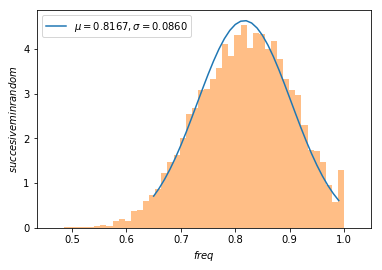

In [55]:
import scipy
import matplotlib.pyplot as plt
from scipy.stats import norm
import matplotlib.mlab as mlab
from scipy import stats  

data = np.array(values_random) 

t=scipy.stats.mstats.normaltest(data)

bins = np.arange(0.65, 1.0, 0.01) # fixed bin size

m, s = stats.norm.fit(data) 
pdf_g = norm.pdf(bins, m, s) # now get theoretical values in our interval  
plt.plot(bins, pdf_g, label='$\mu=0.8167,\sigma=0.0860$') # plot it
plt.legend(loc='best')
plt.xlim([min(data)-0.05, max(data)+0.05])
plt.hist(data, bins='auto', alpha=0.5,normed=True)
plt.xlabel('$freq$')
plt.ylabel('$succesive min random$')
plt.show()

In [56]:
m,s

(0.816765905287002, 0.08603624006630038)

### dos distribuciones 

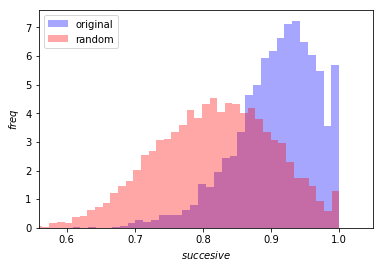

In [57]:
data = np.array(average_succesive_data) 
data_random = np.array(values_random) 

bins = np.arange(0.65, 1.0, 0.01) # fixed bin size

plt.hist(data, bins='auto', alpha=0.35,normed=True,color='blue',label='original')
plt.hist(data_random, bins='auto', alpha=0.35,normed=True,color='red',label='random')

plt.legend(loc='best')
plt.xlim([min(data)-0.05, max(data)+0.05])
plt.xlabel('$succesive$')
plt.ylabel('$freq$')
plt.show()